# TACTIC Application Tutorials

This notebook provides quick tutorials on 2 use cases for the already built `TACTIC` model: 

1. Predicting drug interaction outcomes for new strains*
2. Predicting drug interaction outcomes for new drug combinations+

*based on strains available through [OrtholugeDB](https://ortholugedb.ca/)  
+based on the drug selection available in the omics data used to train the TACTIC model

## Table of Contents: 

[0. Set up environment](#heading_0)  
[1. Predicting outcomes for new strains](#heading_1)  
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Obtain orthology data via OrtholugeDB](#heading_1_1)  
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Create orthology maps](#heading_1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;[1.3 Determine predictions for *K. pneumoniae* strains in LB (runtime: ~10 minutes)](#heading_1_3)  
&nbsp;&nbsp;&nbsp;&nbsp;[1.4 Example analyses](#heading_1_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.1 Strain-to-strain similarity](#heading_1_4_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.2 Narrow-spectrum synergies](#heading_1_4_2)  
[2. Predicting outcomes for new drug combinations](#heading_2)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Determine predictions for 86 new drug pairs (runtime: ~4 minutes)](#heading_2_1)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Determine predictions for 3655 three-way combinations (runtime: ~)](#heading_2_2)  

## 0. Set up environment <a class='anchor' id='heading_0'></a>

Import dependencies:

In [ ]:
# Data handling
import math
import pickle
import webbrowser
import numpy as np
import pandas as pd
from scipy import sparse
from indigopy.core import featurize
from urllib.request import urlopen
from itertools import compress, combinations

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

Load already saved TACTIC data:

In [61]:
# Runtime: ~1 minute
link = 'https://www.dropbox.com/scl/fi/38ewb000ihqcg6wev41g3/TACTIC_data_master.pkl?rlkey=zvxnt71ejj5ucexgpr1plmyvg&dl=1'
ecoli, mtb, master, out = pickle.load(urlopen(link))

Extract data of interest:

In [5]:
# Stressors and strains already evaluated in TACTIC
drugs = [d for d in out['drugs'] if d not in ('GLUCOSE', 'GLYCEROL')]
strains = out['strains']

# Already trained TACTIC model
model = out['model']['TACTIC']

# Print summaries
print('The TACTIC model was built on drug interactions involving {} drugs and {} strains'.format(len(drugs), len(strains)))

The TACTIC model was built on drug interactions involving 86 drugs and 12 strains


## 1. Predicting outcomes for new strains <a class='anchor' id='heading_1'></a>

In the TACTIC study, we predicted drug interaction outcomes in emerging pathogens relating to respiratory (e.g., *M. smegmatis*) and eye (e.g., *P. aeruginosa*) infections. The already built TACTIC model can be extended to predict outcomes in other strains, given that orthology data against the *E. coli* MG1655 and *M. tb* H37Rv genomes is available for the new strain. In this tutorial, we show how to predict strain-specific outcomes in *Klebsiella pneumoniae*, one of the [ESKAPE pathogens](https://pubmed.ncbi.nlm.nih.gov/38831030/). 

### 1.1 Obtain orthology data via OrtholugeDB <a class='anchor' id='heading_1_1'></a>

[OrtholugeDB](https://ortholugedb.ca/) is a database that provides orthology comparisons between bacteria based on their genomes. The code below opens the [webpage](https://ortholugedb.ca/?page=matrix-setup) where we can extract orthology data between reference and comparison genomes: 

In [6]:
# Open genome comparison webpage in OrtholugeDB
webbrowser.open('https://ortholugedb.ca/?page=matrix-setup')

True

<div>
<img src='./data/sample/images/0_OrtholugeDB_setup.png' width='1000'/>
</div>

In this tutorial, our reference genomes are *E. coli* MG1655 and *M. tb* H37Rv. We will use the webpage above to collect gene orthology information for both references. Starting with *E. coli* MG1655, we can type the keyword `mg1655` to quickly find the reference genome: 

<div>
<img src='./data/sample/images/1_MG1655_reference.png' width='1000'/>
</div>

Next, we add *M. tb* H37Rv as the first comparison genome (keyword: `h37rv`): 

<div>
<img src='./data/sample/images/2_H37Rv_comparison.png' width='1000'/>
</div>

We can then search for the available *K. pneumoniae* strains by typing `klebsiella pneumoniae` as a keyword for the comparison genomes: 

<div>
<img src='./data/sample/images/3_Kpneumoniae_comparisons.png' width='1000'/>
</div>

Once we have all genomes of interest selected, we can advance to the next step where we specify the level of orthology information desired. For TACTIC, we recommend leaving the default options: 

<div>
<img src='./data/sample/images/4_gene_filter.png' width='1000'/>
</div>

The results page should look like the following: 

<div>
<img src='./data/sample/images/5_results_page.png' width='1000'/>
</div>

We can download the gene orthology data for *E. coli* MG1655 in either CSV or TAB (recommended) format. To collect gene orthology information for *M. tb* H37Rv as the reference, we can go back to step 1 and specify `h37rv` as the reference genome keyword while selecting `mg1655` to be one of the comparison genomes: 

<div>
<img src='./data/sample/images/6_H37Rv_reference.png' width='1000'/>
</div>

### 1.2 Create orthology maps <a class='anchor' id='heading_1_2'></a>

Using the downloaded files from OrtholugeDB, we can define orhtology maps for each reference strain in the following manner: 

In [81]:
# Load orthology data
orthoDB = {
    'MG1655': pd.read_csv('./data/sample/MG1655_orthologs.txt', sep='\t'), 
    'H37Rv': pd.read_csv('./data/sample/H37Rv_orthologs.txt', sep='\t')
}

# Define orthology map for each reference
ortho_map = {}
for key, value in orthoDB.items(): 
    # Re-format orthology data
    jx = [1, 3] + [x for x in range(4, value.shape[1], 3)]
    df = value.copy().iloc[:, jx]
    df.columns = [s.split(' - ')[0].upper() if 'comparison' in s else s for s in df.columns]
    # Extra step for M. tb H37Rv
    df.iloc[:, 0] = [s.replace('RVBD_', 'Rv') for s in df.iloc[:, 0]]
    # Create orthology map
    ortho_map[key] = {}
    for i in range(2, df.shape[1]): 
        # Define strain name
        cname = df.columns[i]
        if 'MG1655' in cname: 
            strain = 'E. coli MG1655'
        elif 'H37RV' in cname: 
            strain = 'M. tuberculosis H37Rv'
        else: 
            strain = 'K. pneumoniae ' + cname.split('PNEUMONIAE ')[-1]
        # Determine orthologs
        ortho_map[key][strain] = list(compress(df.iloc[:, 0], (df.iloc[:, i] != '0').values))
        print('Number of orthologs for {} against {} reference: {}'.format(strain, key, len(ortho_map[key][strain])))

Number of orthologs for K. pneumoniae HS11286 against MG1655 reference: 3048
Number of orthologs for K. pneumoniae KCTC 2242 against MG1655 reference: 3061
Number of orthologs for M. tuberculosis H37Rv against MG1655 reference: 1124
Number of orthologs for K. pneumoniae 1084 against MG1655 reference: 3037
Number of orthologs for K. pneumoniae NTUH-K2044 against MG1655 reference: 3068
Number of orthologs for K. pneumoniae 342 against MG1655 reference: 3059
Number of orthologs for K. pneumoniae MGH 78578 against MG1655 reference: 3027
Number of orthologs for K. pneumoniae 1084 against H37Rv reference: 1101
Number of orthologs for K. pneumoniae 342 against H37Rv reference: 1107
Number of orthologs for K. pneumoniae MGH 78578 against H37Rv reference: 1102
Number of orthologs for E. coli MG1655 against H37Rv reference: 1064
Number of orthologs for K. pneumoniae KCTC 2242 against H37Rv reference: 1129
Number of orthologs for K. pneumoniae NTUH-K2044 against H37Rv reference: 1116
Number of or

### 1.3 Determine predictions for *K. pneumoniae* strains in LB (runtime: ~10 minutes) <a class='anchor' id='heading_1_3'></a>

Next, we can predict drug interaction outcomes for all pairwise combinations between 86 drugs across all *K. pneumoniae* strains:

In [20]:
# Determine all possible 2-way interactions
interactions = []
for k in range(2, 3):
    interactions.extend(combinations(drugs, k))
interactions = [list(i) for i in interactions]

# Define K. pneumoniae strains
Kp_strains = sorted([s for s in ortho_map['MG1655'].keys() if s.startswith('K.')])

# Define model inputs
i_list = len(Kp_strains) * interactions
s_list = sorted(len(interactions) * Kp_strains)

# Define phenotype data
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()

# Determine ML features
f1      = featurize(i_list, p1, feature_names=g1, key=ecoli['key'], strains=s_list, orthology_map=ortho_map['MG1655'])
f2      = featurize(i_list, p2, feature_names=g2, key=mtb['key'], strains=s_list, orthology_map=ortho_map['H37Rv'])
d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()

# Re-format ML features
x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
X       = sparse.hstack((s1, s2))

# Determine predictions
Kp_predictions = model.predict(X)

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 10950 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 6/6 [00:22<00:00,  3.78s/it]


In [29]:
# Convert prediction data into dataframe
ixns    = [', '.join(ixn) + ', LB' for ixn in i_list]
Kp_df   = pd.DataFrame({'Strain': s_list, 'Interaction': ixns, 'Prediction': Kp_predictions})
Kp_df   = Kp_df.pivot_table(index='Interaction', columns='Strain', sort=False)['Prediction']

### 1.4 Example analyses <a class='anchor' id='heading_1_4'></a>

Based on the predictions we determined, we can carry out several analyses. Here we go over two examples: 

1. Evaluating the similarity in *K. pneumoniae* predictions against predictions previously determined in other strains  
2. Determining narrow-spectrum synergy predictions for *K. pneumoniae* strains compared to commensal bacteria

Before we begin, we will extract data that was previously generated using TACTIC: 

In [45]:
# Extract previously determined predictions
lb_df       = out['landscape']['lb'].copy()

# Define commensal strains
commensal   = [s for s in lb_df.columns if '.' not in s]
lb_df.columns  = [s[0] + '. ' + s.split(' ', 1)[-1] if s in commensal else s for s in lb_df.columns]
commensal   = [s[0] + '. ' + s.split(' ', 1)[-1] for s in commensal]

#### 1.4.1 Strain-to-strain similarity <a class='anchor' id='heading_1_4_1'></a>

Below is an example on how to vizualize the correlation heatmap for strain-to-strain prediction comparisons: 

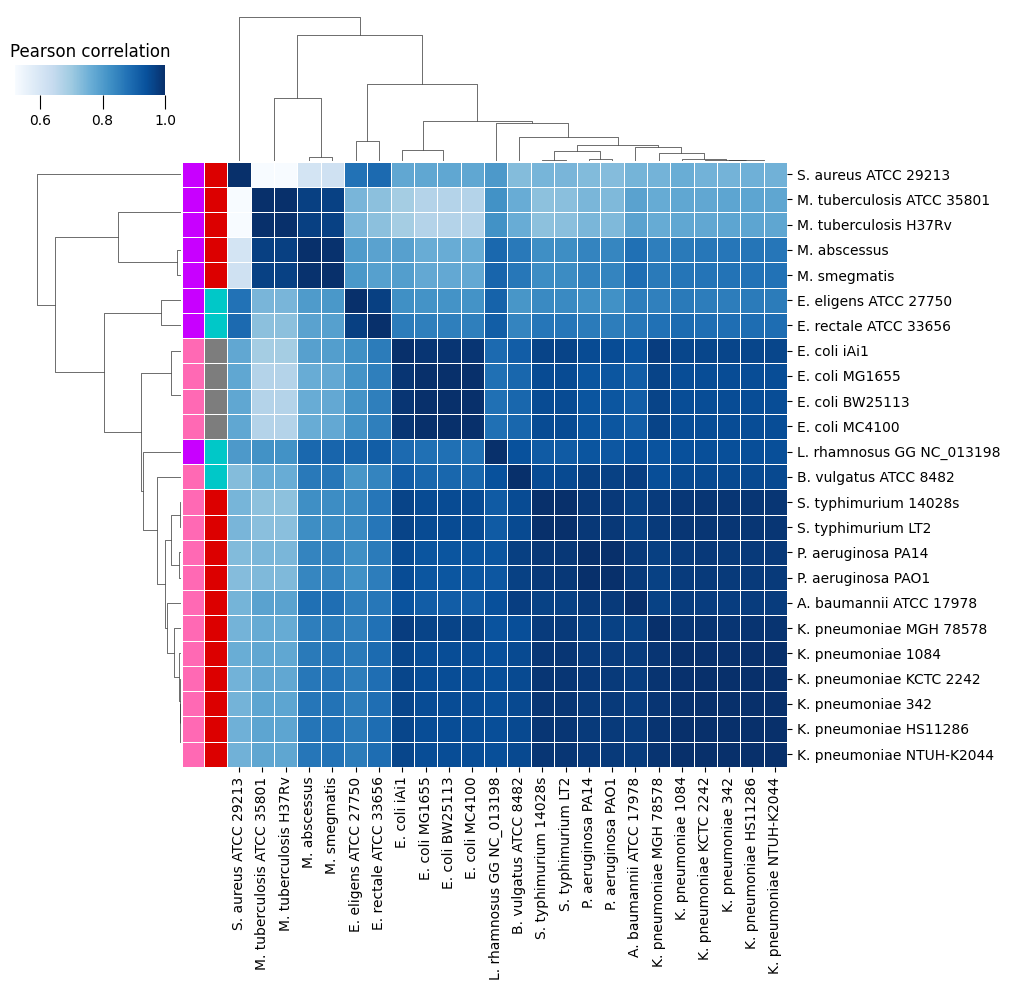

In [46]:
# Combine dataframes
df          = pd.merge(lb_df, Kp_df, how='inner', left_index=True, right_index=True)
streco      = [s for s in df.columns if s.startswith('E. coli')]
pathogens   = [s for s in df.columns if s not in commensal + streco]
group       = streco + pathogens + commensal

# Define metadata (Gram stain + strain group)
gstain  = ['Positive' if s.startswith(('M.', 'S. a', 'E. e', 'E. r', 'L.')) else 'Negative' for s in group]
stype   = len(streco) * ['Model'] + len(pathogens) * ['Pathogen'] + len(commensal) * ['Commensal']
gmap    = {'Positive': [200/255, 0, 255/255], 'Negative': [255/255, 105/255, 180/255]}
tmap    = {'Commensal': [0, 200/255, 200/255], 'Pathogen': [220/255, 0, 0], 'Model': [125/255, 125/255, 125/255]}
grcol   = pd.Series(gstain).map(gmap)
trcol   = pd.Series(stype).map(tmap)

# Generate plot
plot    = df[group].corr(method='pearson')
kws     = dict(cbar_kws=dict(orientation='horizontal'))
cg      = sns.clustermap(plot, row_colors=[grcol, trcol], linewidths=0.5, cmap='Blues', annot=False, **kws)
x0, _, _, _ = cg.cbar_pos
cg.ax_cbar.set_position([0, 0.9, 0.15, 0.03])
cg.ax_cbar.set_title('Pearson correlation')
cg.ax_cbar.tick_params(axis='x', length=10)

The plot above indicates that *K. pneumoniae* predictions are most similar to those in *A. baumannii*

#### 1.4.2 Narrow-spectrum synergies <a class='anchor' id='heading_1_4_2'></a>

Here we define narrow-spectrum synergies as drug interactions predicted to be synergistic (prediction < 0) in *K. pneumoniae* strains and antagonistic or additive (prediction > 0) in commensal strains: 

Syenrgy criterium based on all predictions across group < -0.2.


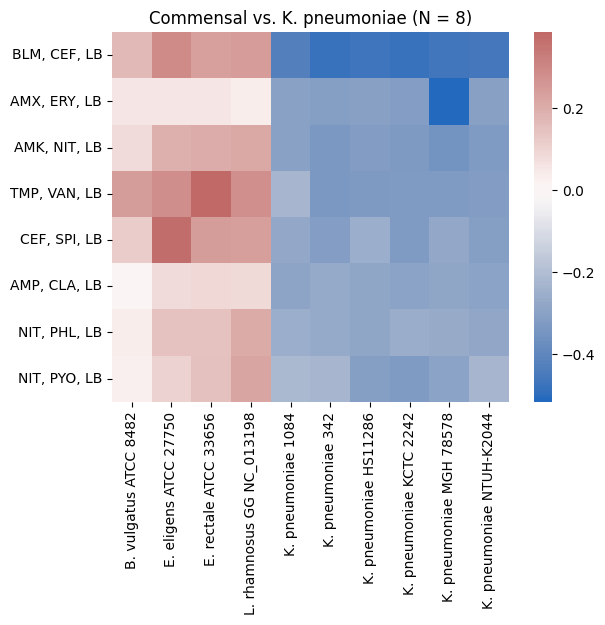

In [47]:
# Define comparison groups
g1, g2 = 'Commensal', 'K. pneumoniae'
s1, s2 = commensal, Kp_strains

# Define narrow-spectrum synergy
ix1 = (df[s1] >= 0).all(axis='columns')
ix2 = (df[s2] < -0.2).all(axis='columns') # strong synergies
if sum(ix1 * ix2 == 1) == 0: 
    ix2 = (df[s2] < 0).all(axis='columns') # all synergies
    if sum(ix1 * ix2 == 1) == 0: 
        ix2 = (df[s2].mean(axis=1) < -0.2) # strong mean synergy
        if sum(ix1 * ix2 == 1) < 10: 
            ix2 = (df[s2].mean(axis=1) < 0) # mean synergy
            print('Synergy criterium based on mean across group < 0.')
        else: 
            print('Synergy criterium based on mean across group < -0.2.')
    else: 
        print('Synergy criterium based on all predictions across group < 0.')
else: 
    print('Syenrgy criterium based on all predictions across group < -0.2.')

# Format data for plotting
mask = [all(ix) for ix in zip(ix1, ix2)]
plot = df.loc[mask][s1 + s2]
x = plot[s1].mean(axis=1)
y = plot[s2].mean(axis=1)
idx = np.argsort(x * y)
idx = np.argsort(y)

# Generate plots
n = 20
if len(idx) <= n: 
    ax = sns.heatmap(plot.iloc[idx], annot=False, cmap='vlag', center=0)
    ax.set_title('{} vs. {} (N = {})'.format(g1, g2, len(idx)))
else: 
    ax = sns.heatmap(plot.iloc[idx[:n]], annot=False, cmap='vlag', center=0)
    ax.set_title('{} vs. {} (top {} out of {})'.format(g1, g2, n, len(idx)))

The plot above indicates that 8 drug interactions have strong narrow-spectrum synergy across *K. pneumoniae* strains.

## 2. Predicting outcomes for new drug combinations <a class='anchor' id='heading_2'></a>

The TACTIC model is trained on two omics datasets:  

1. *E. coli* chemogenomics measured across 324 stressors (Nichols et al., 2011)
2. *M. tb* transcriptomics measured across XX stressors (Ma et al., 2019)

In the TACTIC study, we predicted outcomes for all pairwise combinations between 86 drugs that were represented in the drug interaction dataset used to train the model. However, the TACTIC model is capable of predicting outcomes between any combination between stressors represented in the input omics datasets. In this example, we show how to generate new predictions involving norepinephrine for two cases:  

1. Norepinephrine paired with all 86 drugs that TACTIC is trained on (N = 86)
2. Norepinephrine added to all possible 3655 pairs between 86 drugs (N = 3655)  

Before we begin, we will update the drug key variables to include norepinephrine: 

In [62]:
# Add norepinephrine to MG1655 and H37Rv drug keys
eco_key = ecoli['key'] + [('NE', 'NOREPINEPHRINE-1000')]
mtb_key = mtb['key'] + [('NE', 'NOREPINEPHRINE')]

For the following analyses, we will predict outcomes across all strains for which we have orthology data. Hence, we will update the `ortho_map` variable to include all orthology data:  

In [82]:
# Update orthology maps
ortho_map['MG1655'].update(ecoli['map'])
ortho_map['H37Rv'].update(mtb['map'])

### 2.1 Determine predictions for 86 new drug pairs (runtime: ~4 minutes) <a class='anchor' id='heading_2_1'></a>

Predict outcomes for norepinephrine paired with 86 drugs across 24 strains.

In [85]:
# Define drug pairs
pairs = [[d, 'NE'] for d in drugs]

# Define strains of interest
strains = sorted(list(ortho_map['MG1655'].keys()))

# Define model inputs
i_list = len(strains) * pairs
s_list = sorted(len(pairs) * strains)

# Define phenotype data
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()

# Determine ML features
f1      = featurize(i_list, p1, feature_names=g1, key=eco_key, strains=s_list, orthology_map=ortho_map['MG1655'])
f2      = featurize(i_list, p2, feature_names=g2, key=mtb_key, strains=s_list, orthology_map=ortho_map['H37Rv'])
d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()

# Re-format ML features
x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
X       = sparse.hstack((s1, s2))

# Determine predictions
pair_predictions = model.predict(X)

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 600 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 24/24 [01:05<00:00,  2.73s/it]


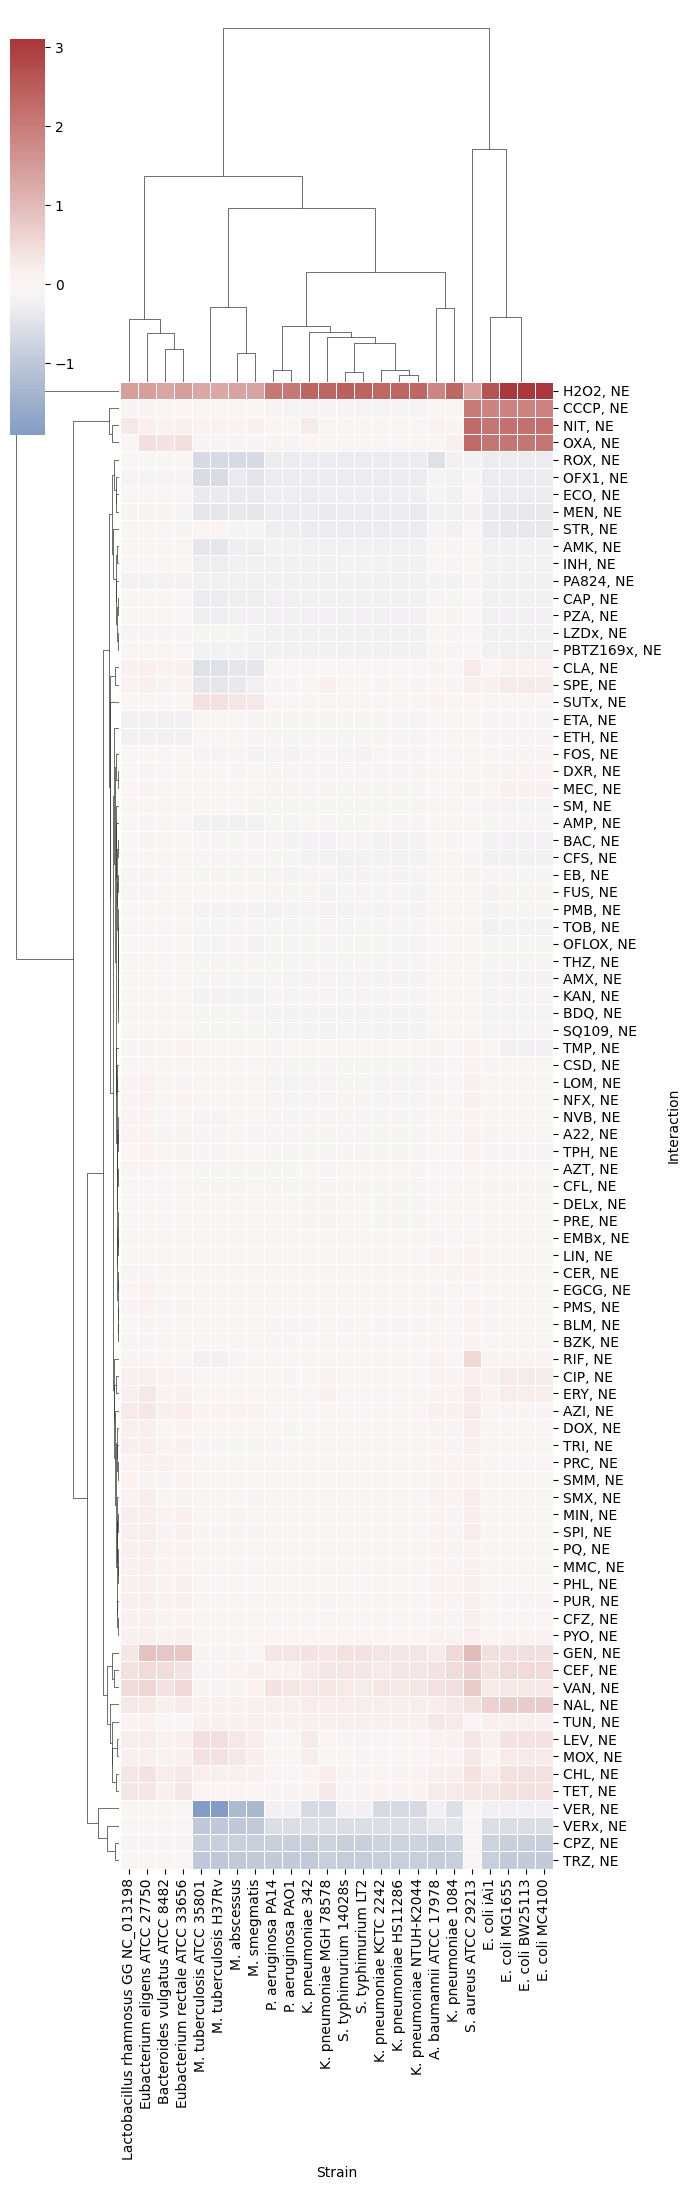

In [98]:
# Convert prediction data into dataframe
ixns    = [', '.join(ixn) for ixn in i_list]
pair_df = pd.DataFrame({'Strain': s_list, 'Interaction': ixns, 'Prediction': pair_predictions})
pair_df = pair_df.pivot_table(index='Interaction', columns='Strain', sort=False)['Prediction']

# Visualize heatmap of predictions
sns.clustermap(pair_df, linewidths=0.5, cmap='vlag', center=0, annot=False, figsize=(7, 22))

### 2.2 Determine predictions for 3655 three-way combinations (runtime: ~8 minutes) <a class='anchor' id='heading_2_2'></a>

Predict outcomes for norepinephrine combined with 3655 drug pairs across *K. pneumoniae* strains.

In [117]:
# Define drug combinations
combos = []
for k in range(2, 3):
    combos.extend(combinations(drugs, k))
combos = [list(i) for i in combos]
for ixn in combos: 
    ixn.append('NE')

# Define model inputs
i_list = len(Kp_strains) * combos
s_list = sorted(len(combos) * Kp_strains)

# Define phenotype data
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()

# Determine ML features
f1      = featurize(i_list, p1, feature_names=g1, key=eco_key, strains=s_list, orthology_map=ortho_map['MG1655'])
f2      = featurize(i_list, p2, feature_names=g2, key=mtb_key, strains=s_list, orthology_map=ortho_map['H37Rv'])
d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()

# Re-format ML features
x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
X       = sparse.hstack((s1, s2))

# Determine predictions
combo_predictions = model.predict(X)

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 10950 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


Text(0.5, 1.0, 'Top 50 synergistic predictions')

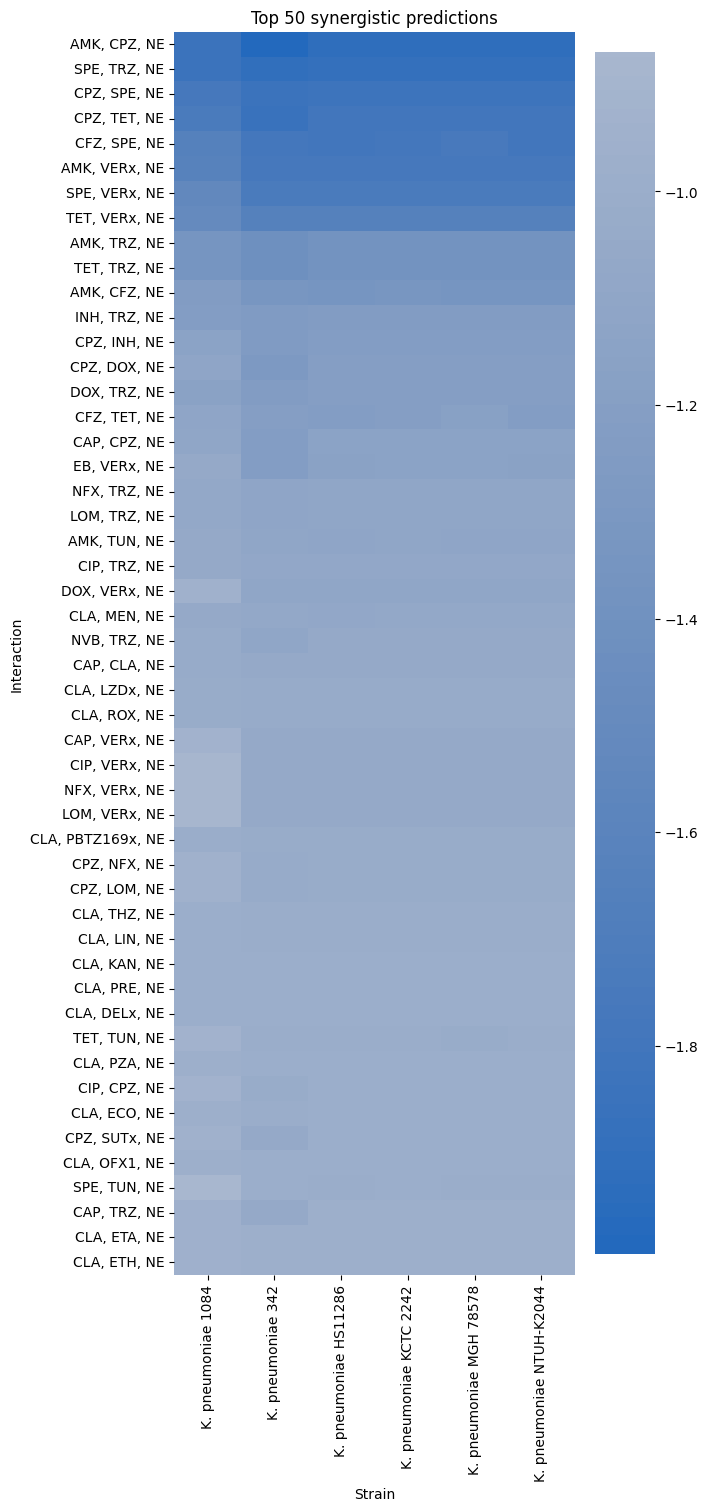

In [124]:
# Convert prediction data into dataframe
ixns     = [', '.join(ixn) for ixn in i_list]
combo_df = pd.DataFrame({'Strain': s_list, 'Interaction': ixns, 'Prediction': combo_predictions})
combo_df = combo_df.pivot_table(index='Interaction', columns='Strain', sort=False)['Prediction']

# Visualize top synergistic predictions
x, n = combo_df.mean(axis=1), 50
idx = np.argsort(x)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 15), constrained_layout=True)
sns.heatmap(combo_df.iloc[idx[:n]], annot=False, cmap='vlag', center=0, ax=ax)
ax.set_title('Top {} synergistic predictions'.format(n))